In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from sklearn.mixture import GaussianMixture
import yfinance as yf

from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.predictors import *
from cvx.covariance.optimal_cov_pred import *
from cvx.covariance.ewma import *


sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
# Industry portfolios
# data = pd.read_csv('../data/factor_data.csv', index_col=0, parse_dates=True)
data = pd.read_csv('../data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate and Fama-French factors
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [3]:
# Rolling window predictor
rolling_window = RollingWindowPredictor(data, memory=125, update_freq=1)
rolling_window.name = "RW-125"

In [4]:
# EWMA predictor
ewma = EwmaPredictor(data, T_half=63)
ewma.name = "EWMA-63"

In [5]:
# Iterated EWMA predictor
iewma = IteratedEwmaPredictor(data, T_half_scale=21, T_half_full=63, init_cutoff=63, lamda=0)
iewma.name = "IEWMA-21-63"

In [6]:
# MGARCH predictor; precomputed in R due to computational complexity
# Note that the covariance matrices were computed for 100*r due to numerical issues 

mgarch_cond_cov = pd.read_csv("../mgarch_predictors_from_R/factor_returns/mgarch_ff5.csv", index_col=None)

Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, data.shape[1])

# Scale down the covariance matrices since they were computed for 100*r 
Sigmas = Sigmas/10000 

mgarch = CovariancePredictor()

# remove first year since it was used for training
mgarch.R = data.iloc[250:] 
mgarch.Sigma_hats = {mgarch.R.index[t]: Sigmas[t] for t in range(Sigmas.shape[0])}
mgarch.n = mgarch.R.shape[1]
mgarch.T = mgarch.R.shape[0]

mgarch.name = "MGARCH"

assert list(mgarch.R.index) == [*mgarch.Sigma_hats.keys()]

In [7]:
# Weighted iterated EWMA predictor
T_halfs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]
const_L = "off"
turnover_cons = None
ignore_dpp = True
cm_iewma = AlternatingWeightedPredictor("iterated_ewma", data, T_halfs, likelihood_memory=10, init_cutoff=63, const_L=const_L,\
     ignore_dpp=ignore_dpp, turnover_cons=turnover_cons,\
       lamdas=[0.05, 0, 0, 0, 0])
cm_iewma.name = "CM-IEWMA"

Solving convex problem for time-varying L...


100%|██████████| 14904/14904 [03:47<00:00, 65.58it/s]


Finishing...


In [8]:
# Prescient predictor
Sigma_hats = {}
for t in data.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    Sigma_hats[t] = np.cov(data.loc[(data.index.year == t.year) & (data.index.quarter == quarter)].values, rowvar=False)

prescient = CovariancePredictor()
prescient.R = data
prescient.Sigma_hats = Sigma_hats
prescient.n = prescient.R.shape[1]
prescient.T = prescient.R.shape[0]
prescient.name = "PRESCIENT"

assert list(prescient.R.index) == [*prescient.Sigma_hats.keys()]

# Define end and start dates for backtests

In [9]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1965-06-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

# CM-IEWMA component weights

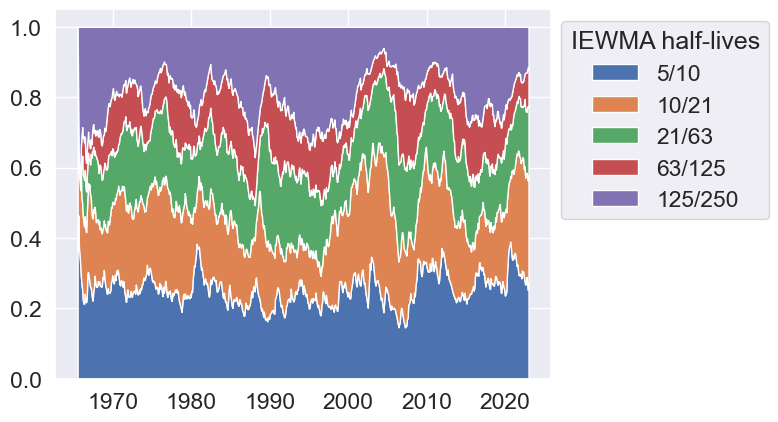

In [11]:
# plot component weights (monthly averages)
weights = cm_iewma.weights.loc[start_date:end_date].resample("M").mean().values
dates=cm_iewma.weights.loc[start_date:end_date].resample("M").mean().index
plt.stackplot(dates, get_ewmas(weights[-cm_iewma.T:], 10).T); 
plt.legend(title="IEWMA half-lives", bbox_to_anchor=(1.23, 1), loc='upper center', ncol=1, labels=[f"{T[0]}/{T[1]}"for T in T_halfs]);


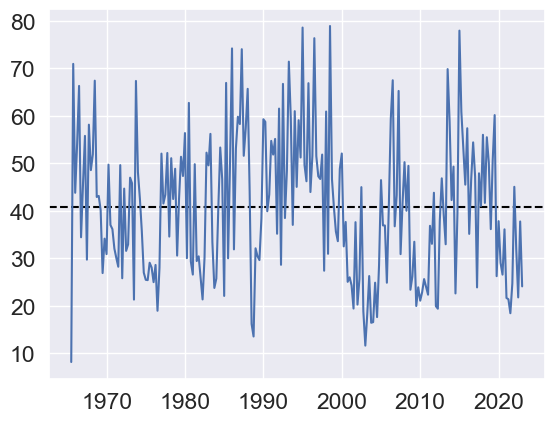

In [12]:
# plot effective half-life (quarterly averages)
T1s = np.array([T_halfs[i][0] for i in range(len(T_halfs))]).reshape(-1,1)
T2s = np.array([T_halfs[i][1] for i in range(len(T_halfs))]).reshape(-1,1)


effective_T1 = pd.DataFrame((cm_iewma.weights.loc[start_date:end_date].values\
     * T1s.T).sum(axis=1),\
    index=cm_iewma.weights.loc[start_date:end_date].index, columns=["T1"])
effective_T2 = pd.DataFrame((cm_iewma.weights.loc[start_date:end_date].values *\
     T2s.T).sum(axis=1),\
    index=cm_iewma.weights.loc[start_date:end_date].index, columns=["T2"])


plt.plot(effective_T1.resample("Q").mean(), label="Effective half-life");
plt.axhline(float(effective_T1.mean()), color="black", linestyle="--", label="Mean half-life", zorder=-1);
# plt.legend();

# Define list of predictors and create Cholesky factors

In [13]:
# List of predictors
predictors = [rolling_window, ewma, iewma, mgarch, cm_iewma, prescient]
labels = [predictor.name for predictor in predictors]

# Get log-likelihoods and Lt_hats (Lt_hats used for some optimization problems)
for predictor in predictors:
    predictor.get_Lt_hats(start_date, end_date)
    predictor.get_log_likelihoods(start_date, end_date)

# Log-likelihood plot (quarterly averages)

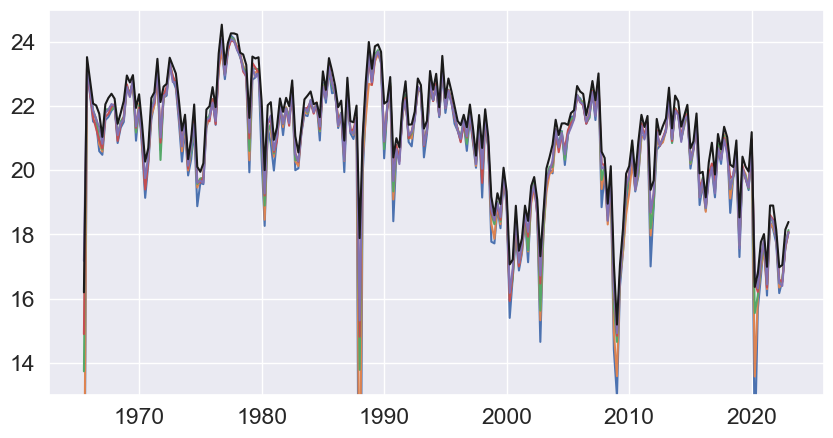

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
prescient_ind = len(predictors)-1
for i, predictor in enumerate(predictors):
    if i==prescient_ind:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean(), c="k")
    else:
        plt.plot(predictor.log_likelihoods.resample("Q").mean().index, \
        predictor.log_likelihoods.resample("Q").mean())

# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
plt.ylim(13,25);

# Regret plot (quarterly averages)

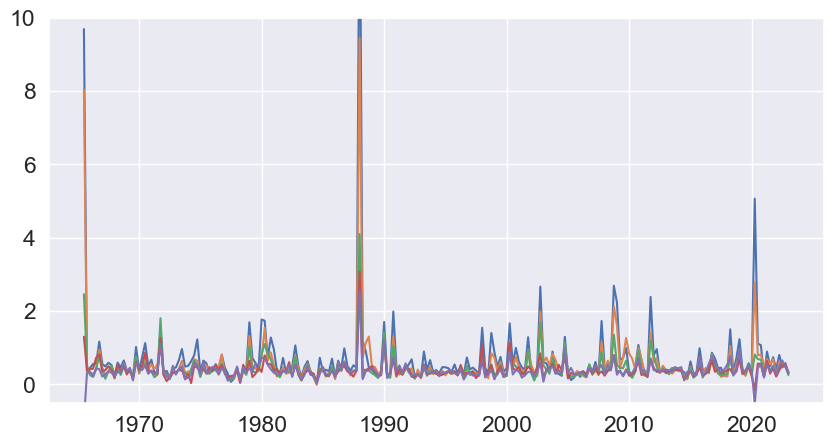

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
all_regrets = []
for i, predictor in enumerate(predictors[:-1]):
    regret =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - predictor.log_likelihoods.resample("Q").mean()
            
    plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret)
    all_regrets.append(regret.values.flatten())

# plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=labels, scatterpoints=1, markerscale=5);
plt.ylim(-0.5,10);


### Compare CM-IEWMA with MGARCH

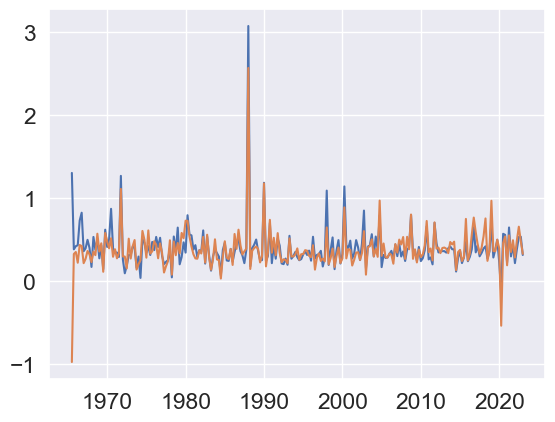

In [16]:
# Regret or W-IT-EWMA and MGARCH
regret_mgarch =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - mgarch.log_likelihoods.resample("Q").mean()

plt.plot(mgarch.log_likelihoods.resample("Q").mean().index, regret_mgarch, label=mgarch.name)

regret_cm_iewma =  prescient.\
        log_likelihoods.resample("Q").mean() \
            - cm_iewma.log_likelihoods.resample("Q").mean()

plt.plot(predictor.log_likelihoods.resample("Q").mean().index, regret_cm_iewma, label=cm_iewma.name);
# plt.legend();

In [17]:
cm_iewma_advantage = ((regret_cm_iewma.values - regret_mgarch.values)<0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 48% of the time


### Regret CDF plots

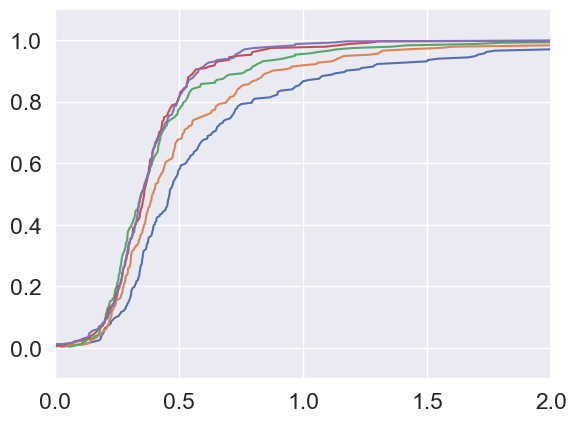

In [18]:
plot_ecdf(all_regrets, labels=labels[:-1])
plt.xlim(0,2)
plt.ylim(-0.1,1.1)
# put label to right of plot
# plt.legend(bbox_to_anchor=(1.27, 1.02), loc='upper center', ncol=1, labels=labels[:-1]);
# Remove legend
plt.legend().remove()

### Regret metrics

In [21]:
### Metrics
print("(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)")

for i, predictor in enumerate(predictors):
    print("\n", labels[i])

    # regret =  predictors[last].log_likelihoods.resample("Q").mean() -\
    #     predictor.log_likelihoods.resample("Q").mean()
    # regret = regret.values
    
    if i < prescient_ind:
        regret = all_regrets[i]
        metrics = (np.mean(regret).round(1), np.std(regret).round(1),\
              np.max(regret).round(1) ,np.quantile(regret, 0.99).round(1),\
            np.quantile(regret, 0.95).round(1), np.quantile(regret, 0.9).round(1))

        print(metrics)
    else:
        print((0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

(Mean, Std, Max, 99th percentile, 95th percentile, 90th percentile)

 RW-125
(0.7, 1.2, 14.6, 4.4, 1.7, 1.2)

 EWMA-63
(0.6, 0.8, 9.5, 2.6, 1.2, 0.9)

 IEWMA-21-63
(0.4, 0.4, 4.1, 1.8, 1.0, 0.8)

 MGARCH
(0.4, 0.3, 3.1, 1.2, 0.8, 0.6)

 CM-IEWMA
(0.4, 0.2, 2.6, 1.1, 0.7, 0.6)

 PRESCIENT
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Portfolio optimization

In [30]:
# Risk-free rate for backtest period; for cash allocation
rf = rf_rate.loc[start_date:end_date]

# Portfolio constraints
additonal_cons={"short_lim":1.6, "upper_bound":0.4,\
             "lower_bound":-0.3}

# Volatility target
sigma_tar = 0.02

### Equally weighted

In [31]:
from cvx.covariance.trading_model import *
adjust_factor = 1

traders_eq_w = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.ws = np.ones(trader.R.shape) / trader.n
    trader.portfolio_type = "eq_weighted"
    trader.adjust_factor = adjust_factor
    traders_eq_w.append(trader)

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


In [32]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_eq_w):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-125
Mean annual return: 2.82%
Annual risk: 2.15%
Sharpe ratio: 1.31
Maximum drawdown: 16.16%

EWMA-63
Mean annual return: 2.89%
Annual risk: 2.04%
Sharpe ratio: 1.42
Maximum drawdown: 14.77%

IEWMA-21-63
Mean annual return: 2.95%
Annual risk: 2.03%
Sharpe ratio: 1.46
Maximum drawdown: 14.02%

MGARCH
Mean annual return: 3.20%
Annual risk: 2.04%
Sharpe ratio: 1.57
Maximum drawdown: 11.58%

CM-IEWMA
Mean annual return: 2.91%
Annual risk: 2.05%
Sharpe ratio: 1.42
Maximum drawdown: 13.78%

PRESCIENT
Mean annual return: 3.35%
Annual risk: 2.03%
Sharpe ratio: 1.65
Maximum drawdown: 13.17%


### Minimum risk

In [33]:
from cvx.covariance.trading_model import *

adjust_factor = 1

C_speedup = False # True if solving using CVXPYgen
traders_min_risk = []

for i in trange(len(predictors)):
     predictor = predictors[i]
     R = predictor.R.loc[start_date:end_date]
     Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
     Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}

     trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
     trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
          C_speedup=C_speedup)
     traders_min_risk.append(trader)


  0%|          | 0/6 [00:00<?, ?it/s]

Adding additional constraints


 17%|█▋        | 1/6 [00:55<04:36, 55.31s/it]

Adding additional constraints


 33%|███▎      | 2/6 [01:50<03:40, 55.12s/it]

Adding additional constraints


 50%|█████     | 3/6 [02:43<02:42, 54.18s/it]

Adding additional constraints


 67%|██████▋   | 4/6 [03:35<01:46, 53.19s/it]

Adding additional constraints


 83%|████████▎ | 5/6 [04:28<00:53, 53.47s/it]

Adding additional constraints


100%|██████████| 6/6 [05:28<00:00, 54.81s/it]


In [34]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=False, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-125
Mean annual return: 2.96%
Annual risk: 2.37%
Sharpe ratio: 1.25
Maximum drawdown: 10.83%

EWMA-63
Mean annual return: 2.89%
Annual risk: 2.35%
Sharpe ratio: 1.23
Maximum drawdown: 9.69%

IEWMA-21-63
Mean annual return: 2.70%
Annual risk: 2.35%
Sharpe ratio: 1.15
Maximum drawdown: 10.16%

MGARCH
Mean annual return: 2.93%
Annual risk: 2.36%
Sharpe ratio: 1.24
Maximum drawdown: 10.70%

CM-IEWMA
Mean annual return: 2.72%
Annual risk: 2.34%
Sharpe ratio: 1.16
Maximum drawdown: 10.10%

PRESCIENT
Mean annual return: 3.10%
Annual risk: 2.14%
Sharpe ratio: 1.45
Maximum drawdown: 8.91%


In [35]:
# Portfolio metrics
excess=True
for i, trader in enumerate(traders_min_risk):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-125
Mean annual return: -2.98%
Annual risk: 2.23%
Sharpe ratio: -1.34
Maximum drawdown: 20.89%

EWMA-63
Mean annual return: -3.00%
Annual risk: 2.08%
Sharpe ratio: -1.44
Maximum drawdown: 18.16%

IEWMA-21-63
Mean annual return: -3.12%
Annual risk: 2.09%
Sharpe ratio: -1.49
Maximum drawdown: 17.42%

MGARCH
Mean annual return: -2.59%
Annual risk: 2.08%
Sharpe ratio: -1.24
Maximum drawdown: 15.16%

CM-IEWMA
Mean annual return: -3.20%
Annual risk: 2.12%
Sharpe ratio: -1.51
Maximum drawdown: 20.55%

PRESCIENT
Mean annual return: -2.91%
Annual risk: 2.04%
Sharpe ratio: -1.42
Maximum drawdown: 19.63%


### Maximum diversification 

In [36]:
from cvx.covariance.trading_model import *

# Only additonal_cons["upper_bound"] relevant for max diverse

adjust_factor = 1

traders_max_diverse = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
         portfolio_type="max_diverse")
    traders_max_diverse.append(trader)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/kasper/opt/anaconda3/envs/cov_pred/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/kasper/opt/anaconda3/envs/cov_pred/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 17%|█▋        | 1/6 [00:13<01:09, 13.88s/it]/Users/kasper/opt/anaconda3/envs/cov_pred/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/kasper/opt/anaconda3/envs/cov_pred/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccur

In [37]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_max_diverse):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-125
Mean annual return: 1.47%
Annual risk: 2.25%
Sharpe ratio: 0.653
Maximum drawdown: 20.94%

EWMA-63
Mean annual return: 1.49%
Annual risk: 2.09%
Sharpe ratio: 0.711
Maximum drawdown: 18.70%

IEWMA-21-63
Mean annual return: 1.44%
Annual risk: 2.08%
Sharpe ratio: 0.695
Maximum drawdown: 18.77%

MGARCH
Mean annual return: 2.03%
Annual risk: 2.06%
Sharpe ratio: 0.988
Maximum drawdown: 16.22%

CM-IEWMA
Mean annual return: 1.41%
Annual risk: 2.10%
Sharpe ratio: 0.671
Maximum drawdown: 17.88%

PRESCIENT
Mean annual return: 1.74%
Annual risk: 2.04%
Sharpe ratio: 0.849
Maximum drawdown: 17.57%


### Risk parity 

In [38]:
from cvx.covariance.trading_model import *
adjust_factor = 1
    
traders_risk_par = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats)
    trader.backtest(adjust_factor=adjust_factor, portfolio_type="risk_parity")
    traders_risk_par.append(trader)

100%|██████████| 6/6 [05:14<00:00, 52.46s/it]


In [39]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_risk_par):
    print("\n"+labels[i])
    trader.diluted = False
    trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)


RW-125
Mean annual return: 1.61%
Annual risk: 2.22%
Sharpe ratio: 0.725
Maximum drawdown: 20.10%

EWMA-63
Mean annual return: 1.64%
Annual risk: 2.07%
Sharpe ratio: 0.793
Maximum drawdown: 18.30%

IEWMA-21-63
Mean annual return: 1.56%
Annual risk: 2.07%
Sharpe ratio: 0.753
Maximum drawdown: 18.12%

MGARCH
Mean annual return: 2.03%
Annual risk: 2.07%
Sharpe ratio: 0.979
Maximum drawdown: 15.82%

CM-IEWMA
Mean annual return: 1.51%
Annual risk: 2.10%
Sharpe ratio: 0.721
Maximum drawdown: 17.15%

PRESCIENT
Mean annual return: 1.76%
Annual risk: 2.04%
Sharpe ratio: 0.861
Maximum drawdown: 18.11%


### Maximum Sharp ratio

In [40]:
from cvx.covariance.trading_model import *
    
# EWMA returns
r_ewma = get_ewmas(data.values, T_half=63)
r_hat_ewma = pd.DataFrame(r_ewma[:-1], index=data.index[1:],\
     columns=data.columns)
r_hat_ewma = r_hat_ewma.loc[start_date:end_date] 

# previous day's returns
# r_hats = pd.DataFrame(data.iloc[:-1].values, index=data.index[1:],\
#      columns=data.columns)
# r_hats = r_hats.loc[start_date:end_date]

traders_max_sharpe = []
for i in trange(len(predictors)):
    predictor = predictors[i]
    R = predictor.R.loc[start_date:end_date]
    Lt_inv_hats = {t: predictor.Lt_inv_hats[t] for t in R.index}
    Sigma_hats = {t: predictor.Sigma_hats[t] for t in R.index}
    
    trader = Trader(R=R, Lt_inv_hats=Lt_inv_hats, Sigma_hats=Sigma_hats,\
    r_hats=r_hat_ewma)
    trader.backtest(adjust_factor=adjust_factor, additonal_cons=additonal_cons,\
        portfolio_type="mean_variance", sigma_des=sigma_tar)
    traders_max_sharpe.append(trader)

100%|██████████| 6/6 [06:13<00:00, 62.21s/it]


In [42]:
# Portfolio metrics
excess=False
for i, trader in enumerate(traders_max_sharpe):
    print("\n"+labels[i])
    trader.get_metrics(diluted_with_cash=False, rf=rf,\
        excess=excess)


RW-125
Mean annual return: 7.56%
Annual risk: 2.38%
Sharpe ratio: 3.17
Maximum drawdown: 4.13%

EWMA-63
Mean annual return: 7.24%
Annual risk: 2.15%
Sharpe ratio: 3.37
Maximum drawdown: 3.74%

IEWMA-21-63
Mean annual return: 7.07%
Annual risk: 2.14%
Sharpe ratio: 3.31
Maximum drawdown: 3.71%

MGARCH
Mean annual return: 7.34%
Annual risk: 2.21%
Sharpe ratio: 3.32
Maximum drawdown: 3.44%

CM-IEWMA
Mean annual return: 6.95%
Annual risk: 2.16%
Sharpe ratio: 3.22
Maximum drawdown: 4.29%

PRESCIENT
Mean annual return: 7.53%
Annual risk: 2.04%
Sharpe ratio: 3.69
Maximum drawdown: 4.04%
